Test en undersamplant pour équilibrer les categories


In [1]:
import importlib

import RktnChallenge.RktnModel
importlib.reload(RktnChallenge.RktnModel)
from RktnChallenge.RktnModel import ModelTrainer



2023-09-08 16:29:56.923312: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-08 16:29:56.951317: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 16:29:57.487605: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import pandas as pd
RktnModel = ModelTrainer("data_tr_lemm.csv")
RktnModel.data['description_length'] = RktnModel.data['description'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
RktnModel.data['designation_length'] = RktnModel.data['designation'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

min_val = RktnModel.data['description_length'].min()
max_val = RktnModel.data['description_length'].max()
RktnModel.data['description_length_normalized'] = (RktnModel.data['description_length'] - min_val) / (max_val - min_val)

min_val = RktnModel.data['designation_length'].min()
max_val = RktnModel.data['designation_length'].max()
RktnModel.data['designation_length_normalized'] = (RktnModel.data['designation_length'] - min_val) / (max_val - min_val)


#RktnModel.saveCSV("data_tr_lemm.csv")

RktnModel.data = RktnModel.data.drop_duplicates(subset=['designation', 'description'])
print(RktnModel.data.shape)

(83493, 27)


Vectorization des données

In [3]:
_X = RktnModel.data["merged_desi_desc"]

RktnModel.create_vectorizer(name="tokenizer", X = _X, ngram_range=(1,3))

X_data = RktnModel.vectorizer_transform(_X)     


y = RktnModel.encodeLabel("prdtypecode")
label_size = RktnModel.getLabelSize()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size = 0.20, random_state = 42)

desi_data = RktnModel.data['designation_length']
desi_train, desi_test= train_test_split(desi_data, test_size = 0.20, random_state = 42)

desc_data = RktnModel.data['description_length']
desc_train, desc_test= train_test_split(desc_data, test_size = 0.20, random_state = 42)




In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Étape 1: Combine data into a single DataFrame
train_df = pd.DataFrame(X_train)  # Suppression de todense() et des noms de colonnes
train_df['prdtypecode'] = y_train
train_df['designation_length'] = desi_train.values
train_df['description_length'] = desc_train.values

# Étape 2: Sous-échantillonnez le DataFrame d'entraînement
min_num = train_df['prdtypecode'].value_counts().min()*3

def undersample_category(group):
    mn = min_num
    if(mn>group.shape[0]):
        mn = group.shape[0]
    return group.sample(mn, random_state=42)

train_df_undersampled = train_df.groupby('prdtypecode').apply(undersample_category).reset_index(drop=True)

# Étape 3: Séparez le DataFrame sous-échantillonné dans les variables d'origine
y_train_undersampled = train_df_undersampled['prdtypecode'].values

# Supprimez les colonnes non nécessaires pour obtenir X_train_undersampled
X_train_undersampled = train_df_undersampled.drop(['prdtypecode', 'designation_length', 'description_length'], axis=1).values

desi_train_undersampled = train_df_undersampled['designation_length'].values
desc_train_undersampled = train_df_undersampled['description_length'].values


Definition d'un modele

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Flatten, Input, concatenate, Dropout

_latent_dim = 600
vocab_size = RktnModel.vocab_size
print(vocab_size)
max_seq_length = RktnModel.max_seq_length

# Entrée de texte
text_input = Input(shape=(max_seq_length,), name='text_input')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=_latent_dim, input_length=max_seq_length, mask_zero=True)(text_input)
flattened_embedding = Flatten()(embedding_layer)

# Deux entrées d'entiers
int_input1 = Input(shape=(1,), name='length_input')
int_input2 = Input(shape=(1,), name='length_input2')

# Concaténation des trois entrées
concatenated = concatenate([flattened_embedding, int_input1, int_input2])

x = Dropout(0.5)(concatenated)
output = Dense(units=label_size, activation="softmax")(x)

model = tf.keras.Model(inputs=[text_input, int_input1, int_input2], outputs=output)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])




142167


In [19]:
model.fit([X_train_undersampled, desi_train_undersampled, desc_train_undersampled], y_train_undersampled, epochs=10, batch_size=100,validation_split=0.2)

Epoch 1/10
306/306 [==============================] - 35s 113ms/step - loss: 2.2807 - accuracy: 0.5289 - val_loss: 20.6254 - val_accuracy: 0.0208
Epoch 2/10
306/306 [==============================] - 27s 87ms/step - loss: 0.5095 - accuracy: 0.8649 - val_loss: 20.4936 - val_accuracy: 0.0221
Epoch 3/10
306/306 [==============================] - 23s 75ms/step - loss: 0.2249 - accuracy: 0.9487 - val_loss: 21.5990 - val_accuracy: 0.0219
Epoch 4/10
306/306 [==============================] - 22s 72ms/step - loss: 0.0947 - accuracy: 0.9826 - val_loss: 20.9015 - val_accuracy: 0.0221
Epoch 5/10
306/306 [==============================] - 19s 64ms/step - loss: 0.0738 - accuracy: 0.9891 - val_loss: 21.3340 - val_accuracy: 0.0221
Epoch 6/10
306/306 [==============================] - 18s 60ms/step - loss: 0.0501 - accuracy: 0.9933 - val_loss: 22.4400 - val_accuracy: 0.0219
Epoch 7/10
306/306 [==============================] - 18s 58ms/step - loss: 0.0393 - accuracy: 0.9951 - val_loss: 23.0962 - val_a

KeyboardInterrupt: 

522/522 [==============================] - 2s 4ms/step
weighted F1 score: 0.5733540173984664


/home/pec/Rktn/RktnChallenge/RktnModel.py:190: RuntimeWarning: invalid value encountered in divide
  normalized_conf_matrix = conf_matrix / row_sums[ np.newaxis,:]*100


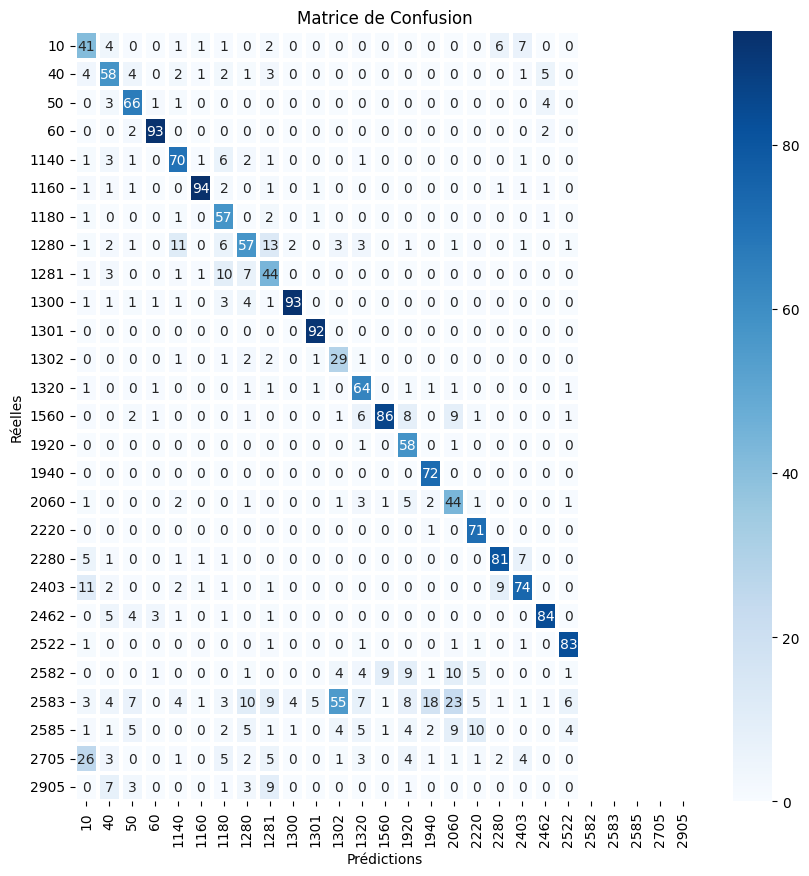

In [20]:
y_pred_test = model.predict([X_test,desi_test,desc_test])
y_pred_id = y_pred_test.argmax(axis=-1)

RktnModel.evaluateTestResults(y_test,y_pred_id)

209
